In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import math
from scipy.special import gamma
from scipy.optimize import bisect
from scipy.stats import norm
from utils import *
%config Completer.use_jedi=False
from tqdm.notebook import trange
import matplotlib.pyplot as plt

import torch
torch.set_printoptions(precision=6)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [19]:
from torch.utils.data import random_split, DataLoader

In [2]:
import os
os.chdir('Data')

In [29]:
import gzip
f= gzip.GzipFile("impliedVols_total.txt.gz","r")
df = np.load(f)[:180000]
xx = df[:, :15]
yy = df[:, 15:]
len(df), len(df[0])

(180000, 87)

In [26]:
S0 = 1.
r = 0.
logmoneyness = np.array([-0.15, -0.12, -0.09, -0.06, -0.03, 0.0, 0.03, 0.06, 0.09, 0.12, 0.15, 0.18])
strikes=np.exp(S0*logmoneyness)
maturities=np.array([0.05,0.15,0.3,0.4,0.5,0.6])
strikes_dim = len(strikes)
maturities_dim = len(maturities)
strikes_dim, maturities_dim

(12, 6)

In [7]:
ub=np.max(xx, axis=0)
lb=np.min(xx, axis=0)
def myscale(x):
    res=np.zeros(len(xx[0]))
    for i in range(len(xx[0])):
        res[i]=(x[i] - (ub[i] + lb[i])*0.5) * 2 / (ub[i] - lb[i])
    return res

def myinverse(x):
    res=np.zeros(len(xx[0]))
    for i in range(len(xx[0])):
        res[i]=x[i]*(ub[i] - lb[i]) *0.5 + (ub[i] + lb[i])*0.5
    return res

In [51]:
xx_scale = np.array([myscale(x) for x in xx])
print(xx_scale.shape)
df_scale = np.hstack((xx_scale, yy))
print(df_scale.shape)
train, validation, test = random_split(df_scale,[int(0.8*df_len), int(0.1*df_len), int(0.1*df_len)])
print(train.dataset.shape, validation.dataset.shape, test.dataset.shape)
train_set = [(x[:15], x[15:]) for x in train.dataset]
val_set = [(x[:15], x[15:]) for x in validation.dataset]
test_set = [(x[:15], x[15:]) for x in test.dataset]

(180000, 15)
(180000, 87)
(180000, 87) (180000, 87) (180000, 87)


In [49]:
import torch.nn as nn

class qrHestonModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(qrHestonModel, self).__init__()
        self.l1 = nn.Linear(input_dim, hidden_dim)
        self.silu1 = nn.SiLU()
        
        self.l2 = nn.Linear(hidden_dim, hidden_dim)
        self.silu2 = nn.SiLU()
        
        self.l3 = nn.Linear(hidden_dim, hidden_dim)
        self.silu3 = nn.SiLU()
        
        self.l4 = nn.Linear(hidden_dim, hidden_dim)
        self.silu4 = nn.SiLU()
        
        self.l5 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        out = self.l1(x)
        out = self.silu1(out)
        
        out = self.l2(out)
        out = self.silu2(out)
        
        out = self.l3(out)
        out = self.silu3(out)
        
        out = self.l4(out)
        out = self.silu4(out)
        
        out = self.l5(out)
        
        return out

In [50]:
batch_size = 128
num_epochs = 200

input_dim = len(xx[0])
output_dim = strikes_dim*maturities_dim
hidden_dim = 32

model = qrHestonModel(input_dim, hidden_dim, output_dim)
model.to(device)

qrHestonModel(
  (l1): Linear(in_features=15, out_features=32, bias=True)
  (silu1): SiLU()
  (l2): Linear(in_features=32, out_features=32, bias=True)
  (silu2): SiLU()
  (l3): Linear(in_features=32, out_features=32, bias=True)
  (silu3): SiLU()
  (l4): Linear(in_features=32, out_features=32, bias=True)
  (silu4): SiLU()
  (l5): Linear(in_features=32, out_features=72, bias=True)
)

In [11]:
loss_mse = nn.MSELoss()
learning_rate  = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [90]:
train_loader = torch.utils.data.DataLoader(dataset = train_set, batch_size = batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_set, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_set, batch_size = batch_size, shuffle=True)
first_batch = train_loader.__iter__().__next__()
print('{:<21s} | {:<25s} | {}'.format('name', 'type', 'size')) # 21s and 25s is character spaces of string
print('{:<21s} | {:<25s} | {}'.format('Number of Mini-Batchs', '', len(train_loader)))
print('{:<21s} | {:<25s} | {}'.format('first_batch', str(type(first_batch)), len(first_batch)))
print('{:<21s} | {:<25s} | {}'.format('first_batch[0]', str(type(first_batch[0])), first_batch[0].shape))
print('{:<21s} | {:<25s} | {}'.format('first_batch[1]', str(type(first_batch[1])), first_batch[1].shape))

name                  | type                      | size
Number of Mini-Batchs |                           | 1407
first_batch           | <class 'list'>            | 2
first_batch[0]        | <class 'torch.Tensor'>    | torch.Size([128, 15])
first_batch[1]        | <class 'torch.Tensor'>    | torch.Size([128, 72])


In [53]:
model.train()

qrHestonModel(
  (l1): Linear(in_features=15, out_features=32, bias=True)
  (silu1): SiLU()
  (l2): Linear(in_features=32, out_features=32, bias=True)
  (silu2): SiLU()
  (l3): Linear(in_features=32, out_features=32, bias=True)
  (silu3): SiLU()
  (l4): Linear(in_features=32, out_features=32, bias=True)
  (silu4): SiLU()
  (l5): Linear(in_features=32, out_features=72, bias=True)
)

In [78]:
int_training_step = 1
for epoch in range(10):
    train_loss = 0.0
    for data, target_tensor in train_loader:
        data = data.to(device).float()
        target_tensor = target_tensor.to(device).float()
#         print(data.dtype, target_tensor.dtype)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_mse(output, target_tensor)
        loss.backward()
        optimizer.step()
        train_loss = loss.item()*data.size(0)
        
    valid_loss = 0.0
    model.eval()
    for data, target_tensor in val_loader:
        data = data.to(device).float()
        target_tensor = target_tensor.to(device).float()
        output = model(data)
        loss = loss_mse(output, target_tensor)
        valid_loss = loss.item()*data.size(0)

    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(val_loader)}')  
#         if int_training_step %1000 == 0:
#             loss_print = loss.item()
#             print(f"Train Step: {int_training_step}\t Loss: {loss_print}")
#         int_training_step +=1

Epoch 1 		 Training Loss: 0.00480121742687754 		 Validation Loss: 0.0050174039394701294
Epoch 2 		 Training Loss: 0.004822852345502538 		 Validation Loss: 0.00461893549351804
Epoch 3 		 Training Loss: 0.004280267239633654 		 Validation Loss: 0.0046825164925060805
Epoch 4 		 Training Loss: 0.006412432900369803 		 Validation Loss: 0.00479282448286695
Epoch 5 		 Training Loss: 0.005363548064621611 		 Validation Loss: 0.005486348036255664
Epoch 6 		 Training Loss: 0.004233157626262521 		 Validation Loss: 0.004766453049584492
Epoch 7 		 Training Loss: 0.0037973047404231634 		 Validation Loss: 0.003608733775688556
Epoch 8 		 Training Loss: 0.005515232099737779 		 Validation Loss: 0.004738074968957528
Epoch 9 		 Training Loss: 0.004010716650447018 		 Validation Loss: 0.0036674789613074417
Epoch 10 		 Training Loss: 0.003790272493775889 		 Validation Loss: 0.0060147344430626585


In [57]:
model.eval()

qrHestonModel(
  (l1): Linear(in_features=15, out_features=32, bias=True)
  (silu1): SiLU()
  (l2): Linear(in_features=32, out_features=32, bias=True)
  (silu2): SiLU()
  (l3): Linear(in_features=32, out_features=32, bias=True)
  (silu3): SiLU()
  (l4): Linear(in_features=32, out_features=32, bias=True)
  (silu4): SiLU()
  (l5): Linear(in_features=32, out_features=72, bias=True)
)

In [101]:
test_loss = []
i = 0
prediction = []
for data, target_tensor in test_loader:
    data = data.to(device).float()
    target_tensor = target_tensor.to(device)
    output = model(data).float()
    for i in output.detach().numpy():
        prediction.append(i)
    loss = loss_mse(output, target_tensor).item()
    test_loss.append(loss*data.size(0))


<ipython-input-103-d70ce07bb5f5>:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(maturities)


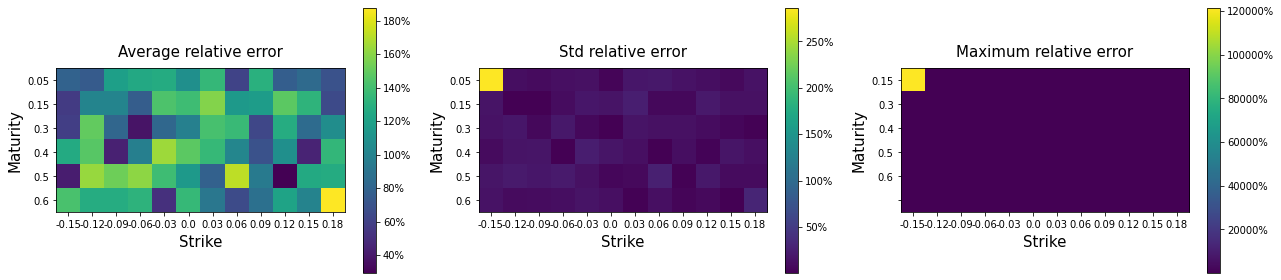

In [103]:
##### AVERAGE VALUES #######
import matplotlib.ticker as mtick

y_sample = test.dataset[:, 15:]

plt.figure(1,figsize=(18,4))
ax=plt.subplot(1,3,1)
# err = np.array([100*np.mean(e) for e in err_CI95]) 
err = np.mean(100*np.abs((y_sample-prediction)/y_sample),axis = 0)
plt.title("Average relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())

ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
# ax.set_xticklabels(np.round(strikes,2))
ax.set_xticklabels(logmoneyness)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

ax=plt.subplot(1,3,2)
# err = np.array([100*np.std(e) for e in err_CI95]) 
err = 100*np.std(np.abs((y_sample-prediction)/y_sample),axis = 0)
plt.title("Std relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
# ax.set_xticklabels(strikes)
ax.set_xticklabels(logmoneyness)

ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

ax=plt.subplot(1,3,3)
# err = np.array([100*np.max(e) for e in err_CI95]) 
err = 100*np.max(np.abs((y_sample-prediction)/y_sample),axis = 0)
plt.title("Maximum relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
# ax.set_xticklabels(strikes)
ax.set_xticklabels(logmoneyness)
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
plt.tight_layout()
# plt.savefig('qrHestonNNErrors.png', dpi=300)
plt.show()
